# Time Series Forecast
### Overview
This project implements various machine learning algorithms to forecast energy consumption patterns. By using historical energy consumption data, each model will predict future energy usage in order to help improve grid management and resource planning.

### Project Goals
- ***Primary Objective***: Develop an accurate time-series forecasting model for hourly energy consumption.  
- ***Business Objective***: Enable better energy resource planning and grid management for power companies.  
- ***Technical Objective***: Utilize predictive modeling to handle complex temporal patterns in energy usage.  

### Approach


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import AEP energy usage dataset as Pandas DataFrame
energy_df = pd.read_csv('data/energy/AEP_hourly.csv', 
                        parse_dates=['Datetime'], 
                        index_col='Datetime')
energy_df = energy_df.sort_index()
energy_df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


### 1. Data Validation and Cleaning
After importing the dataset into my environment, I like to profile the data to ensure it is complete prior to proceeding with downstream analysis.

In [3]:
# Check for NULL values in the dataset
print("NULL Values:")
print(energy_df.isnull().sum())

NULL Values:
AEP_MW    0
dtype: int64


In [4]:
energy_df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [5]:
# Examine the date range of the dataset
print("Earliest Date:", energy_df.index.min())
print("Latest Date:", energy_df.index.max())

Earliest Date: 2004-10-01 01:00:00
Latest Date: 2018-08-03 00:00:00


### 2. Feature Creation

In [6]:
# Create features from datetime index that will allow for more robust time series modeling
def create_features(df, lag_hours = [1, 2, 3, 6, 12, 24, 48, 168]):
    
    # Create time series features based on datetime index
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week'] = df.index.isocalendar().week

    # Lag features
    for lag in lag_hours:
        df[f'lag_{lag}'] = df['AEP_MW'].shift(lag)

    # Rolling window statistics
    df['rolling_mean_24h'] = df['AEP_MW'].shift(1).rolling(window=24).mean()
    df['rolling_std_24h'] = df['AEP_MW'].shift(1).rolling(window=24).std()
    df['rolling_mean_168h'] = df['AEP_MW'].shift(1).rolling(window=168).mean()
    df['rolling_std_168h'] = df['AEP_MW'].shift(1).rolling(window=168).std()

    # Cyclical encoding for hour (helps model understand hour 23 is close to hour 0 and month 12 is close to month 1)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    return df

In [7]:
# Create a new dataframe by adding datetime features to the energy usage data
df = create_features(energy_df)
# Drop rows with NaN values created by lag and rolling features
df = df.dropna()  
df.head()

,AEP_MW,hour,day_of_week,month,quarter,year,day_of_year,day_of_month,week,lag_1,...,lag_48,lag_168,rolling_mean_24h,rolling_std_24h,rolling_mean_168h,rolling_std_168h,hour_sin,hour_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-10-08 01:00:00,12468.0,1,4,10,4,2004,282,8,41,13271.0,...,12764.0,12379.0,14450.333333,1475.548466,13870.315476,1602.840398,0.258819,0.965926,-0.866025,0.5
2004-10-08 02:00:00,12046.0,2,4,10,4,2004,282,8,41,12468.0,...,12347.0,11935.0,14449.666667,1476.478821,13870.845238,1602.359181,0.500000,0.866025,-0.866025,0.5
2004-10-08 03:00:00,11749.0,3,4,10,4,2004,282,8,41,12046.0,...,12192.0,11692.0,14449.333333,1477.043983,13871.505952,1601.578873,0.707107,0.707107,-0.866025,0.5
2004-10-08 04:00:00,11784.0,4,4,10,4,2004,282,8,41,11749.0,...,12164.0,11597.0,14449.500000,1476.725755,13871.845238,1601.120364,0.866025,0.500000,-0.866025,0.5
2004-10-08 05:00:00,11919.0,5,4,10,4,2004,282,8,41,11784.0,...,12356.0,11681.0,14450.625000,1474.594117,13872.958333,1599.593700,0.965926,0.258819,-0.866025,0.5


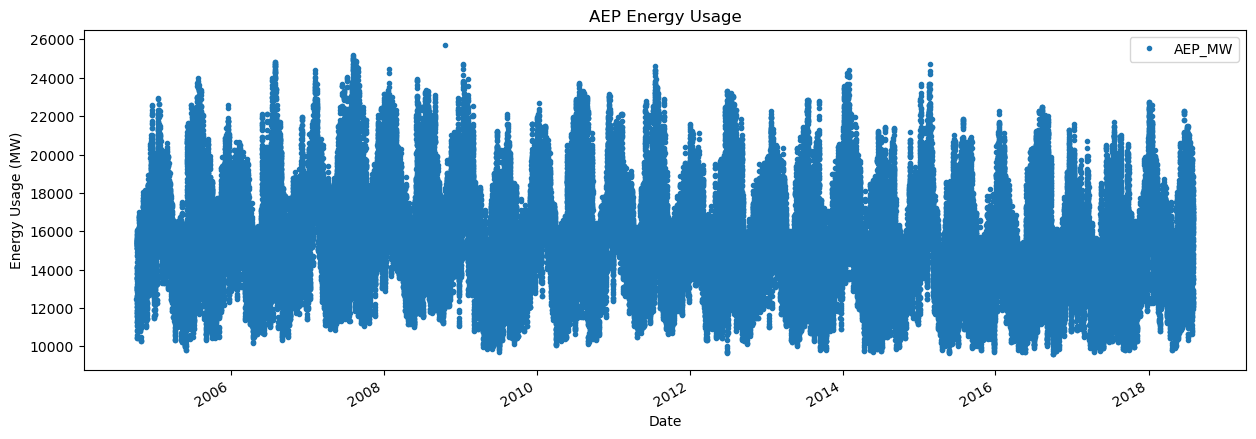

In [8]:

df.plot(y='AEP_MW',
        figsize=(15,5),
        title="AEP Energy Usage",
        style='.')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.show()

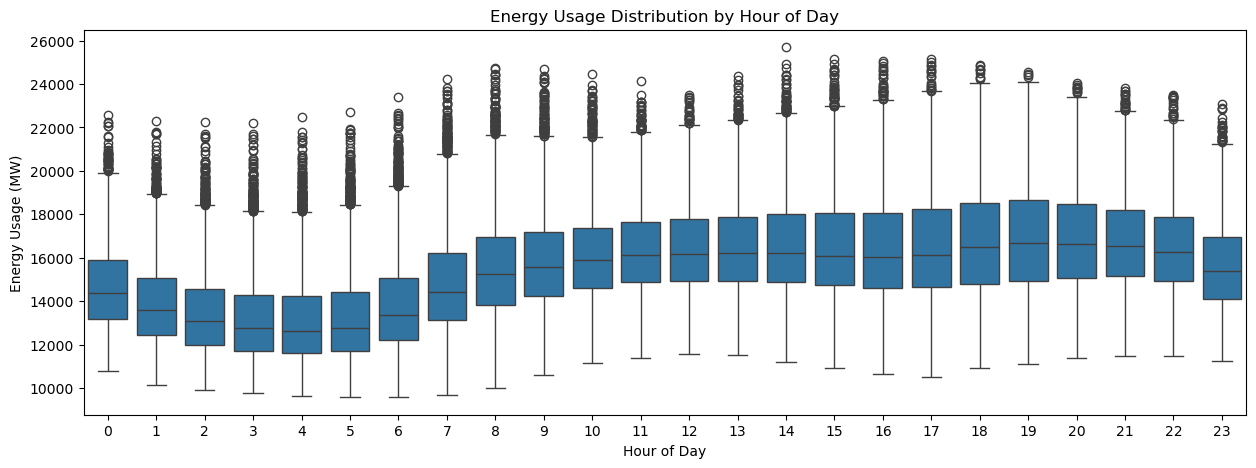

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['hour'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Hour of Day")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Hour of Day')
plt.show()

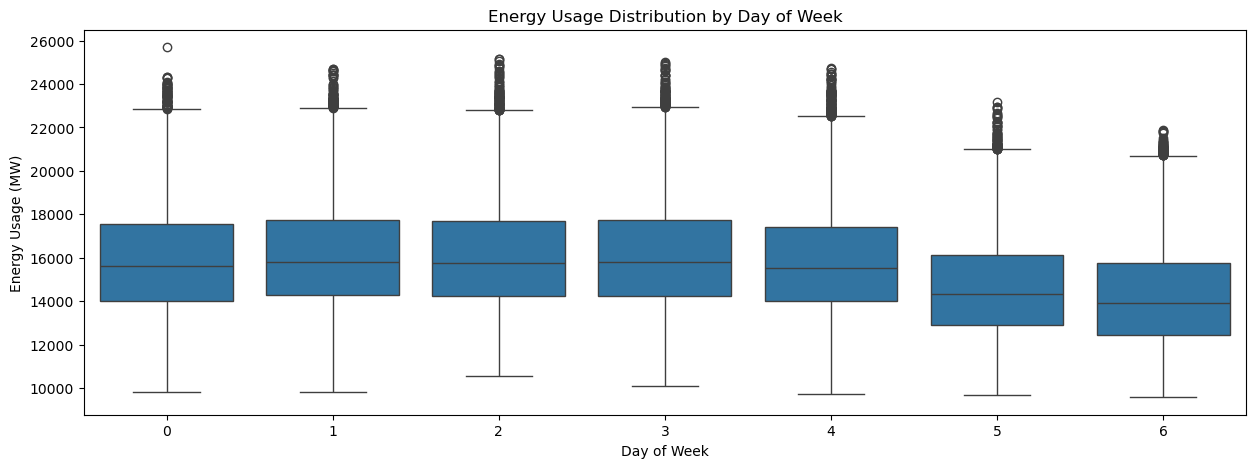

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['day_of_week'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Day of Week")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Day of Week')
plt.show()

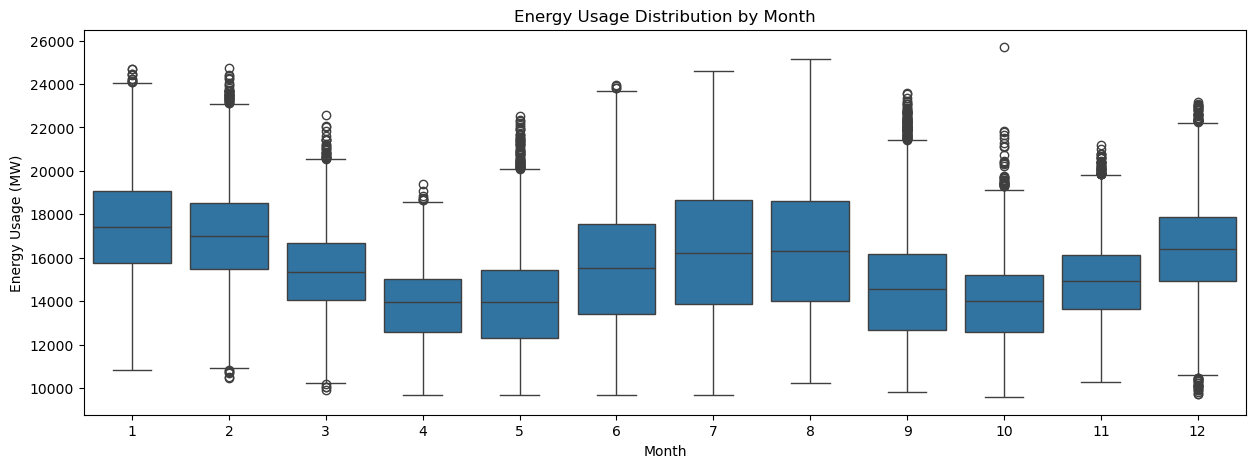

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['month'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Month")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Month')
plt.show()

### 3. Split Training and Testing Datasets

In [12]:
# Split the data into training and testing sets (80% train:20% test)
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print(f"Training set range: {train.index.min()} -> {train.index.max()}")
print(f"Testing set range: {test.index.min()} -> {test.index.max()}")

# Divide the train/test sets into features(X) and target(y)
X_train = train.drop('AEP_MW', axis=1)
y_train = train['AEP_MW']
X_test = test.drop('AEP_MW', axis=1)
y_test = test['AEP_MW']

Training set range: 2004-10-08 01:00:00 -> 2015-10-28 19:00:00
Testing set range: 2015-10-28 20:00:00 -> 2018-08-03 00:00:00


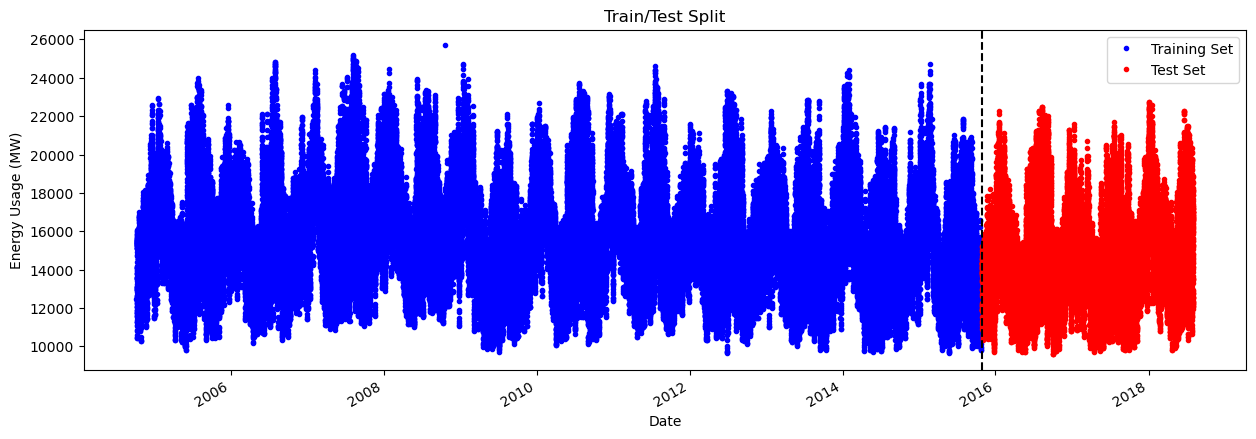

In [13]:
# Plot the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='AEP_MW', ax=ax, label='Train Set', style='.', color='blue')
test.plot(y='AEP_MW', ax=ax, label='Test Set', style='.', color='red')
plt.title("Train/Test Split")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(x=test.index.min(), color='black', linestyle='--' , label='Train/Test Split')
plt.show()

### 4. Training the Models

In [14]:
# XGBoost Model Training and Hyperparameter Tuning
xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 1000, 
    early_stopping_rounds = None, 
    learning_rate = 0.01,
    max_depth = 5,
    random_state = 11)

xgb_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 10]
}

tscv = TimeSeriesSplit(
    n_splits=5,
    gap=7
)

xgb_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = xgb_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Best Score: {xgb_grid_search.best_score_}")

xgb_pred = xgb_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000}
Best Score: -26682.211010738647


In [15]:
# LightGBM Model Training and Hyperparameter Tuning
lgbm_model = lgb.LGBMRegressor(
    objective = 'regression',
    n_estimators = 500,
    learning_rate = 0.01,
    max_depth = 5,
    random_state = 11
)

lgbm_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

lgbm_grid_search = GridSearchCV(
    estimator = lgbm_model,
    param_grid = lgbm_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

lgbm_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {lgbm_grid_search.best_params_}")
print(f"Best Score: {lgbm_grid_search.best_score_}")

lgbm_pred = lgbm_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 96884, number of used features: 24
[LightGBM] [Info] Start training from score 15697.995624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Best Score: -26478.286255241874


In [16]:
# Random Forest Model Training and Hyperparameter Tuning
rf_model = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 5,
    min_samples_split = 5,
    n_jobs = -1,
    random_state = 11,
    verbose = False
)

rf_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10]
}

rf_grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid = rf_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

rf_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Best Score: {rf_grid_search.best_score_}")

rf_pred = rf_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: -49778.122777746714


In [17]:
# Prophet Model Training
prophet_train = train.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
prophet_test = test.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
prophet_test = prophet_test[['ds']]

prophet_model = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

prophet_model.fit(prophet_train)
prophet_forecast = prophet_model.predict(prophet_test)
prophet_pred = prophet_forecast['yhat'].values

16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
results = {}

results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),
    'MAE': mean_absolute_error(y_test, xgb_pred),
    'MAPE': np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100,
    'R2': r2_score(y_test, xgb_pred),
    'predictions': xgb_pred
}
results['LightGBM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, lgbm_pred)),
    'MAE': mean_absolute_error(y_test, lgbm_pred),
    'MAPE': np.mean(np.abs((y_test - lgbm_pred) / y_test)) * 100,
    'R2': r2_score(y_test, lgbm_pred),
    'predictions': lgbm_pred
}
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
    'MAE': mean_absolute_error(y_test, rf_pred),
    'MAPE': np.mean(np.abs((y_test - rf_pred) / y_test)) * 100,
    'R2': r2_score(y_test, rf_pred),
    'predictions': rf_pred
}
results['Prophet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, prophet_pred)),
    'MAE': mean_absolute_error(y_test, prophet_pred),
    'MAPE': np.mean(np.abs((y_test - prophet_pred) / y_test)) * 100,
    'R2': r2_score(y_test, prophet_pred),
    'predictions': prophet_pred
}

In [19]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'MAPE (%)': [results[m]['MAPE'] for m in results.keys()],
    'R2': [results[m]['R2'] for m in results.keys()]
}).sort_values('RMSE')

In [20]:
results_df

,Model,RMSE,MAE,MAPE (%),R2
1,LightGBM,140.296588,103.934698,0.714420,0.996709
0,XGBoost,141.267957,104.975512,0.721455,0.996663
2,Random Forest,217.033523,162.456288,1.113005,0.992125
3,Prophet,2173.352891,1716.305470,11.918816,0.210273


In [21]:
test['xgb_prediction'] = xgb_pred
test['lgbm_prediction'] = lgbm_pred
test['rf_prediction'] = rf_pred
test['prophet_prediction'] = prophet_pred
df = df.merge(test[['xgb_prediction', 'lgbm_prediction', 'rf_prediction', 'prophet_prediction']], how='left', left_index=True, right_index=True)

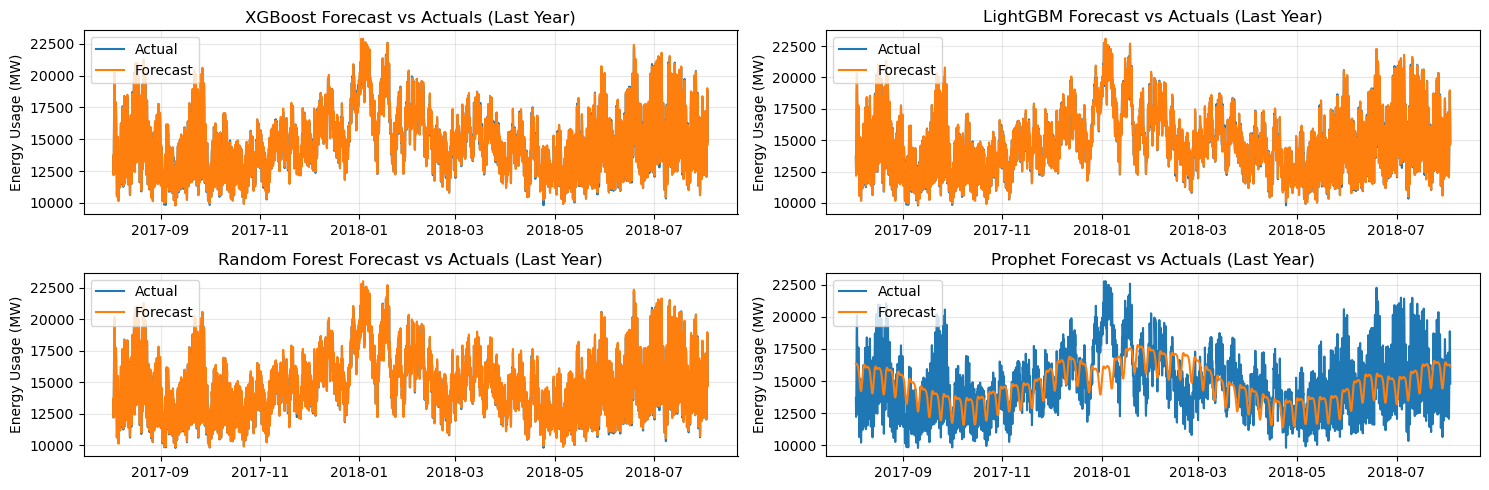

In [22]:
fig, axes = plt.subplots(2,2, figsize=(15,5))
last_year = test.tail(24*365)

for i, (model, ax) in enumerate(zip(['XGBoost', 'LightGBM', 'Random Forest', 'Prophet'], axes.flatten())):
    pred_col = ['xgb_prediction', 'lgbm_prediction', 'rf_prediction', 'prophet_prediction'][i]

    ax.plot(last_year.index, last_year['AEP_MW'], label = 'Actual')
    ax.plot(last_year.index, last_year[pred_col], label = 'Forecast')
    ax.set_title(f"{model} Forecast vs Actuals (Last Year)")
    ax.set_ylabel('Energy Usage (MW)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

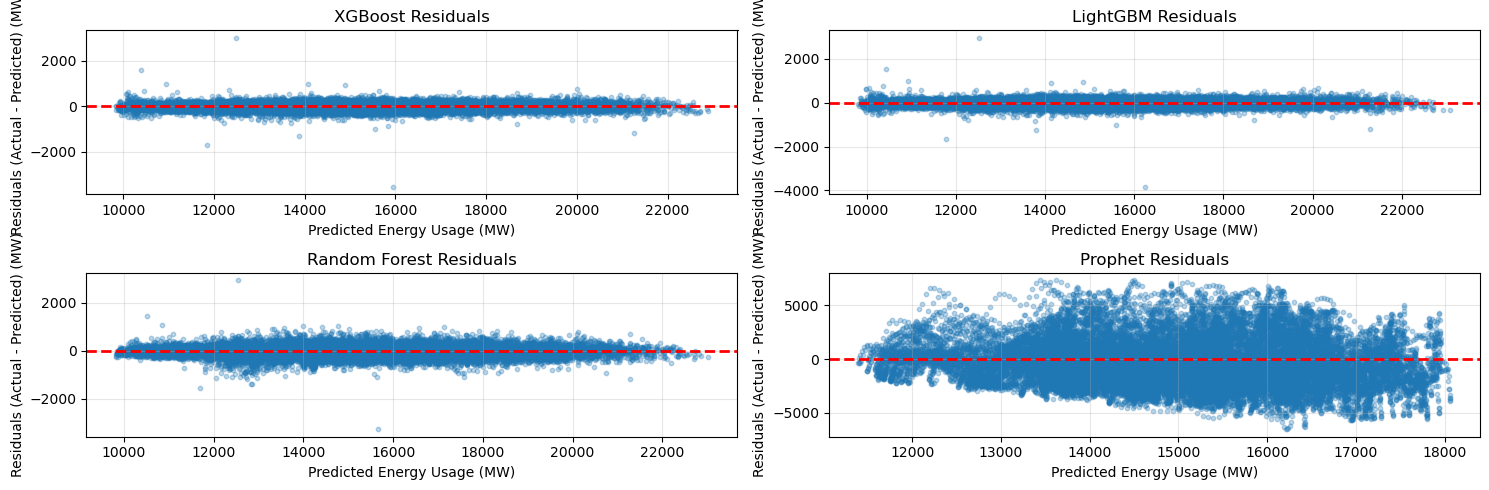

In [23]:
fig, axes = plt.subplots(2,2, figsize=(15,5))

for i, (model, pred_col) in enumerate(zip(
    ['XGBoost', 'LightGBM', 'Random Forest', 'Prophet'], 
    ['xgb_prediction', 'lgbm_prediction', 'rf_prediction', 'prophet_prediction'])):
    ax = axes.flatten()[i]
    residuals = test['AEP_MW'] - test[pred_col]

    ax.scatter(test[pred_col], residuals, alpha = 0.3, s = 10)
    ax.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2)
    ax.set_title(f"{model} Residuals")
    ax.set_xlabel('Predicted Energy Usage (MW)')
    ax.set_ylabel('Residuals (Actual - Predicted) (MW)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

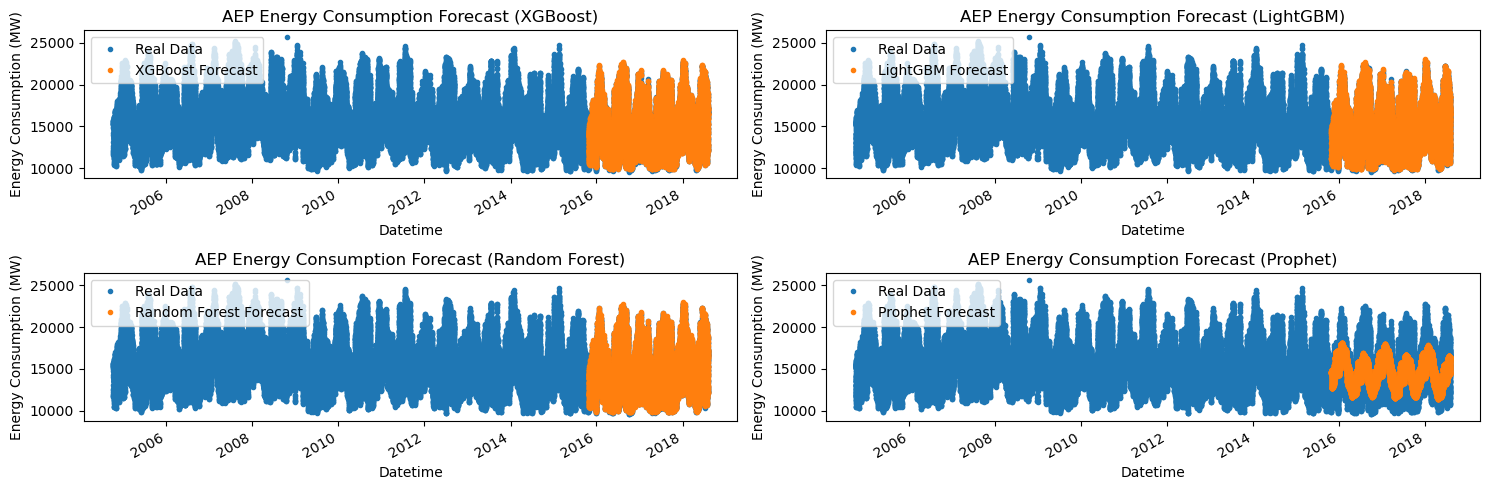

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
ax00 = ax[0,0]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[0,0])
df['xgb_prediction'].plot(ax=ax[0,0], style='.')
ax00.set_title('AEP Energy Consumption Forecast (XGBoost)')
ax00.set_ylabel('Energy Consumption (MW)')
ax00.legend(['Real Data','XGBoost Forecast'], loc = 'upper left')

ax01 = ax[0,1]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[0,1])
df['lgbm_prediction'].plot(ax=ax[0,1], style='.')
ax01.set_title('AEP Energy Consumption Forecast (LightGBM)')
ax01.set_ylabel('Energy Consumption (MW)')
ax01.legend(['Real Data','LightGBM Forecast'], loc = 'upper left')

ax10 = ax[1,0]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[1,0])
df['rf_prediction'].plot(ax=ax[1,0], style='.')
ax10.set_title('AEP Energy Consumption Forecast (Random Forest)')
ax10.set_ylabel('Energy Consumption (MW)')
ax10.legend(['Real Data','Random Forest Forecast'], loc = 'upper left')

ax11 = ax[1,1]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[1,1])
df['prophet_prediction'].plot(ax=ax[1,1], style='.')
ax11.set_title('AEP Energy Consumption Forecast (Prophet)')
ax11.set_ylabel('Energy Consumption (MW)')
ax11.legend(['Real Data','Prophet Forecast'], loc = 'upper left')

plt.tight_layout()
plt.show()